# VIABILL - Case assignment
Wojciech Wróbel

## Imports

In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sqlite3

from scipy.stats import kruskal
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, RocCurveDisplay, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV

## Connection with the database
Let's create connection and import tables into dataframes

In [2]:
conn = sqlite3.connect('viabill.db')

In [3]:
customers = pd.read_sql_query("SELECT * FROM customers", conn)
transactions = pd.read_sql_query("SELECT * FROM transactions", conn)

In [4]:
customers.head()

,customerID,sex,age,residentialAddress,postalAddress,income
0,1,1,25,28 Irvine Place,28 Irvine Place,NaN
1,2,1,19,72 Bertha Street,72 Bertha Street,43200.0
2,3,2,22,63 Ladberry Street,63 Ladberry Street,70200.0
3,4,0,24,98 Linneman Close,98 Linneman Close,93900.0
4,5,1,53,56 Salonica Road,56 Salonica Road,77000.0


In [5]:
transactions.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4
0,1,114,2869,140,0,0,0,0
1,2,855,124077,70,0,0,0,0
2,3,752,86184,85,0,0,0,0
3,4,246,248861,43,1,0,0,0
4,5,973,162112,127,0,0,0,0


Both tables imported successfully

## Task 3
Check if there is a dependency between age and sex in the data – use statistical test if 
applicable

Let's have a look into the data:

In [75]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customerID          500000 non-null  int64  
 1   sex                 500000 non-null  int64  
 2   age                 500000 non-null  int64  
 3   residentialAddress  500000 non-null  object 
 4   postalAddress       500000 non-null  object 
 5   income              490025 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 22.9+ MB


In [237]:
customers[['age', 'sex']].groupby('sex').describe()

age                                                   
        count       mean        std  min   25%   50%   75%   max
sex                                                             
0     25127.0  44.668245  16.157586  9.0  27.0  50.0  57.0  86.0
1    374545.0  44.610717  16.179729  5.0  27.0  50.0  58.0  88.0
2    100328.0  44.694941  16.178041  7.0  27.0  50.0  58.0  90.0

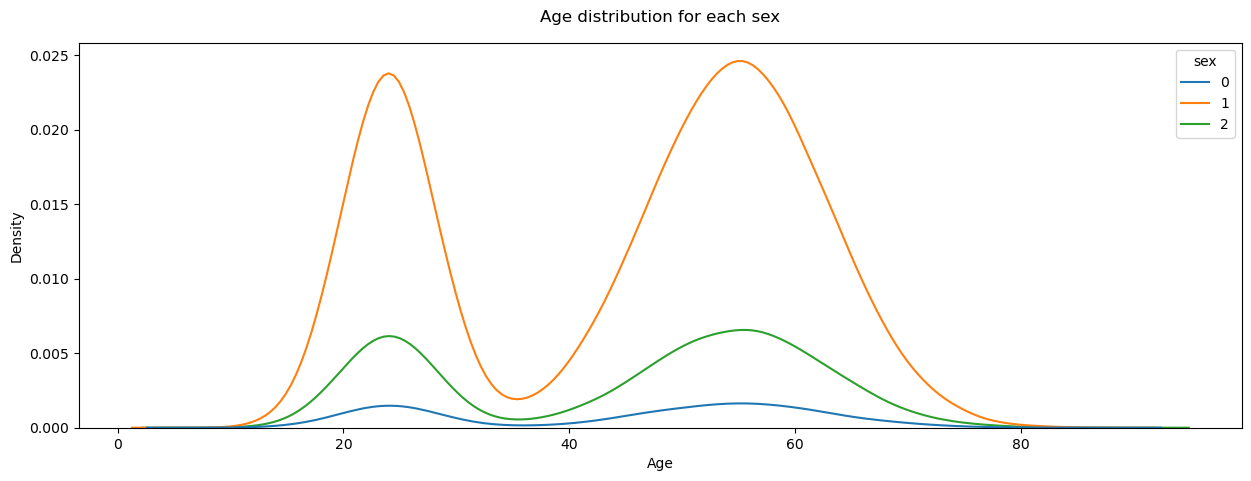

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

nbins = 30

sns.kdeplot(
    data=customers,
    x='age',
    hue='sex',
    palette=sns.color_palette(n_colors=3)
)

ax.set_title('Age distribution for each sex', pad=15)
ax.set_xlabel('Age')

plt.show()

As can be seen in the plot - there is no normal distribution. There is bimodal distribution instead.

Up to this moment I checked the average age values for each sex. What's more - there are 3 values available in this column, so I assumed there would be "female", "male" and "refusal of the answer" values. Thus I didn't replace any value with any other.

What's more - looking at mean and standard deviation of age per each sex we can tell that there is no dependency between age and sex, but we will prove it using Kruskall-Wallis test. This test will be used, because there are 3 categorical variables and one continuous variable with no normal distribution. We would use ANOVA if there was normal distribution and Mann-Whitney U test if there were just 2 sexes available.

Lastly - presence of five-year-olds between loan program customers is intriguing.

In [32]:
kruskal_test = kruskal(
    customers[customers['sex']==0]['age'],
    customers[customers['sex']==1]['age'],
    customers[customers['sex']==2]['age'],
)
print(kruskal_test)

KruskalResult(statistic=2.42379366215206, pvalue=0.2976321856766056)


In Kruskal-Wallis test we take as null hypothesis fact, that medians of all the sets are the same. Due to high p-value (more than 0.05) we have no statistical proof to reject the null hypothesis and tell that sex has impact on customers age.

## EDA 
Before challenging tasks 4, 5 and 6 I will conduct the exploratory data analysis to get familiar with the data.

I am creating a dataframe transactions_facts that will combine customers facts with their transactions for easier plotting. Some transactions had missing customerID, but on this stage I will not drop rows with missing columns, because they should be useful while exploring the data.

In [6]:
transactions.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   transactionID    2000000 non-null  int64 
 1   shopID           2000000 non-null  int64 
 2   customerID       2000000 non-null  object
 3   price            2000000 non-null  int64 
 4   paytmentStatus1  2000000 non-null  int64 
 5   paytmentStatus2  2000000 non-null  int64 
 6   paytmentStatus3  2000000 non-null  int64 
 7   paytmentStatus4  2000000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 122.1+ MB


In [8]:
transactions_facts = pd.merge(transactions, customers, on='customerID', how='left')
transactions_facts['delayed_payments'] = (transactions_facts[['paytmentStatus1', 'paytmentStatus2', 'paytmentStatus3', 'paytmentStatus4']] == 1).sum(axis=1)
transactions_facts['unpaid_payments'] = (transactions_facts[['paytmentStatus1', 'paytmentStatus2', 'paytmentStatus3', 'paytmentStatus4']] == 2).sum(axis=1)
transactions_facts['shopID'] = transactions_facts['shopID'].astype('str')
transactions_facts['customerID'] = pd.to_numeric(transactions_facts['customerID'], errors='coerce') # Replace empty customerID cell with NaN
transactions_facts['paytmentStatus1'] = transactions_facts['paytmentStatus1'].astype('str')
transactions_facts['paytmentStatus2'] = transactions_facts['paytmentStatus2'].astype('str')
transactions_facts['paytmentStatus3'] = transactions_facts['paytmentStatus3'].astype('str')
transactions_facts['paytmentStatus4'] = transactions_facts['paytmentStatus4'].astype('str')
transactions_facts['sex'] = transactions_facts['sex'].astype('str')

transactions_facts.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,delayed_payments,unpaid_payments
0,1,114,2869.0,140,0,0,0,0,2.0,24.0,74 Ada Street,74 Ada Street,54900.0,0,0
1,2,855,124077.0,70,0,0,0,0,1.0,46.0,23 Brampton Street,23 Brampton Street,60000.0,0,0
2,3,752,86184.0,85,0,0,0,0,1.0,52.0,96 Avon Street,35 Spurwood Street,7100.0,0,0
3,4,246,248861.0,43,1,0,0,0,1.0,29.0,3 Merinda Street,3 Merinda Street,67600.0,1,0
4,5,973,162112.0,127,0,0,0,0,2.0,30.0,64 Distribution Street,64 Distribution Street,92000.0,0,0


In [9]:
transactions_facts.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   transactionID       2000000 non-null  int64  
 1   shopID              2000000 non-null  object 
 2   customerID          1979983 non-null  float64
 3   price               2000000 non-null  int64  
 4   paytmentStatus1     2000000 non-null  object 
 5   paytmentStatus2     2000000 non-null  object 
 6   paytmentStatus3     2000000 non-null  object 
 7   paytmentStatus4     2000000 non-null  object 
 8   sex                 2000000 non-null  object 
 9   age                 1979983 non-null  float64
 10  residentialAddress  1979983 non-null  object 
 11  postalAddress       1979983 non-null  object 
 12  income              1940494 non-null  float64
 13  delayed_payments    2000000 non-null  int64  
 14  unpaid_payments     2000000 non-null  int64  
dtypes: float64(3), 

### Price distribution for transactions with given number of delayed or unpaid payments

In [111]:
print(transactions_facts['delayed_payments'].value_counts(),'\n\n')
print(transactions_facts['unpaid_payments'].value_counts())

delayed_payments
0    1397656
1     475985
2      95480
3      10375
4        487
Name: count, dtype: int64 


unpaid_payments
0    1797760
1      81486
2      43903
3      30732
4      26102
Name: count, dtype: int64


Due to imbalance in classes the plots will be created with given weights.

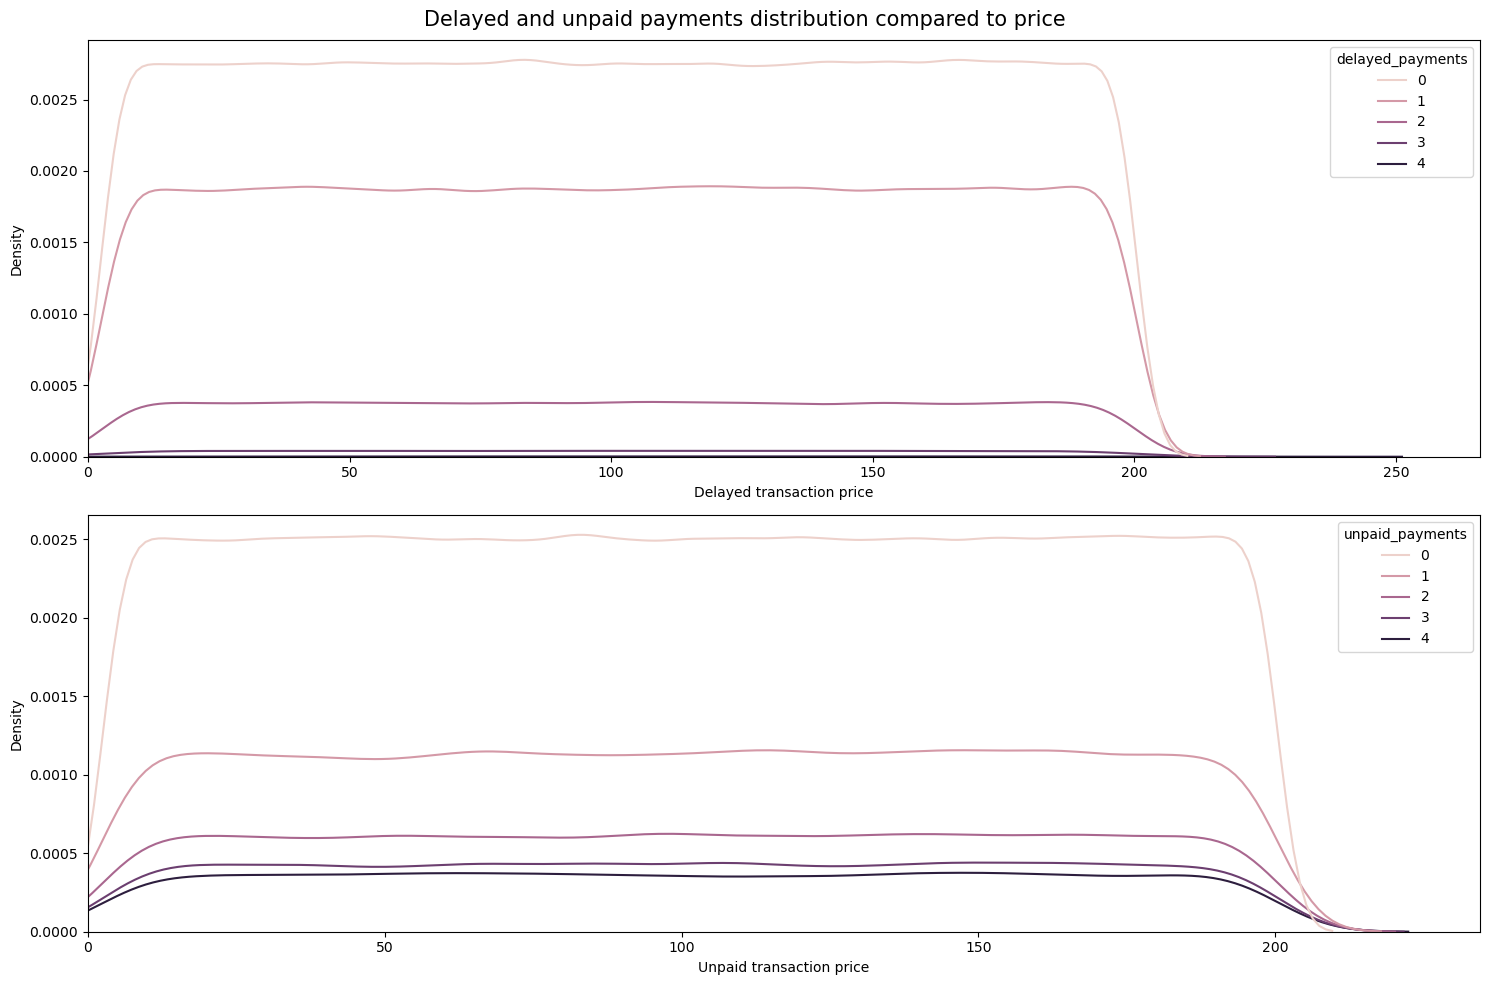

In [17]:
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))

transactions_facts_plot = transactions_facts.copy()
transactions_facts_plot['delayed_weight'] = np.where(transactions_facts_plot['delayed_payments'] == 0, 0.5, 1)
transactions_facts_plot['unpaid_weight'] = np.where(transactions_facts_plot['unpaid_payments'] == 0, 0.1, 1)

sns.kdeplot(
    ax=ax0,
    data=transactions_facts_plot,
    x='price',
    hue='delayed_payments',
    weights='delayed_weight'
)

sns.kdeplot(
    ax=ax1,
    data=transactions_facts_plot,
    x='price',
    hue='unpaid_payments',
    weights='unpaid_weight'
)

ax0.set_xlabel('Delayed transaction price')
ax1.set_xlabel('Unpaid transaction price')
ax0.set_xlim(0)
ax1.set_xlim(0)

fig.suptitle('Delayed and unpaid payments distribution compared to price', fontsize=15)
fig.tight_layout()

plt.show()

Surprisingly, there is no correlation between price and possibility of delay or refusal to pay. This data would only cause noise in the analysis.

### Income

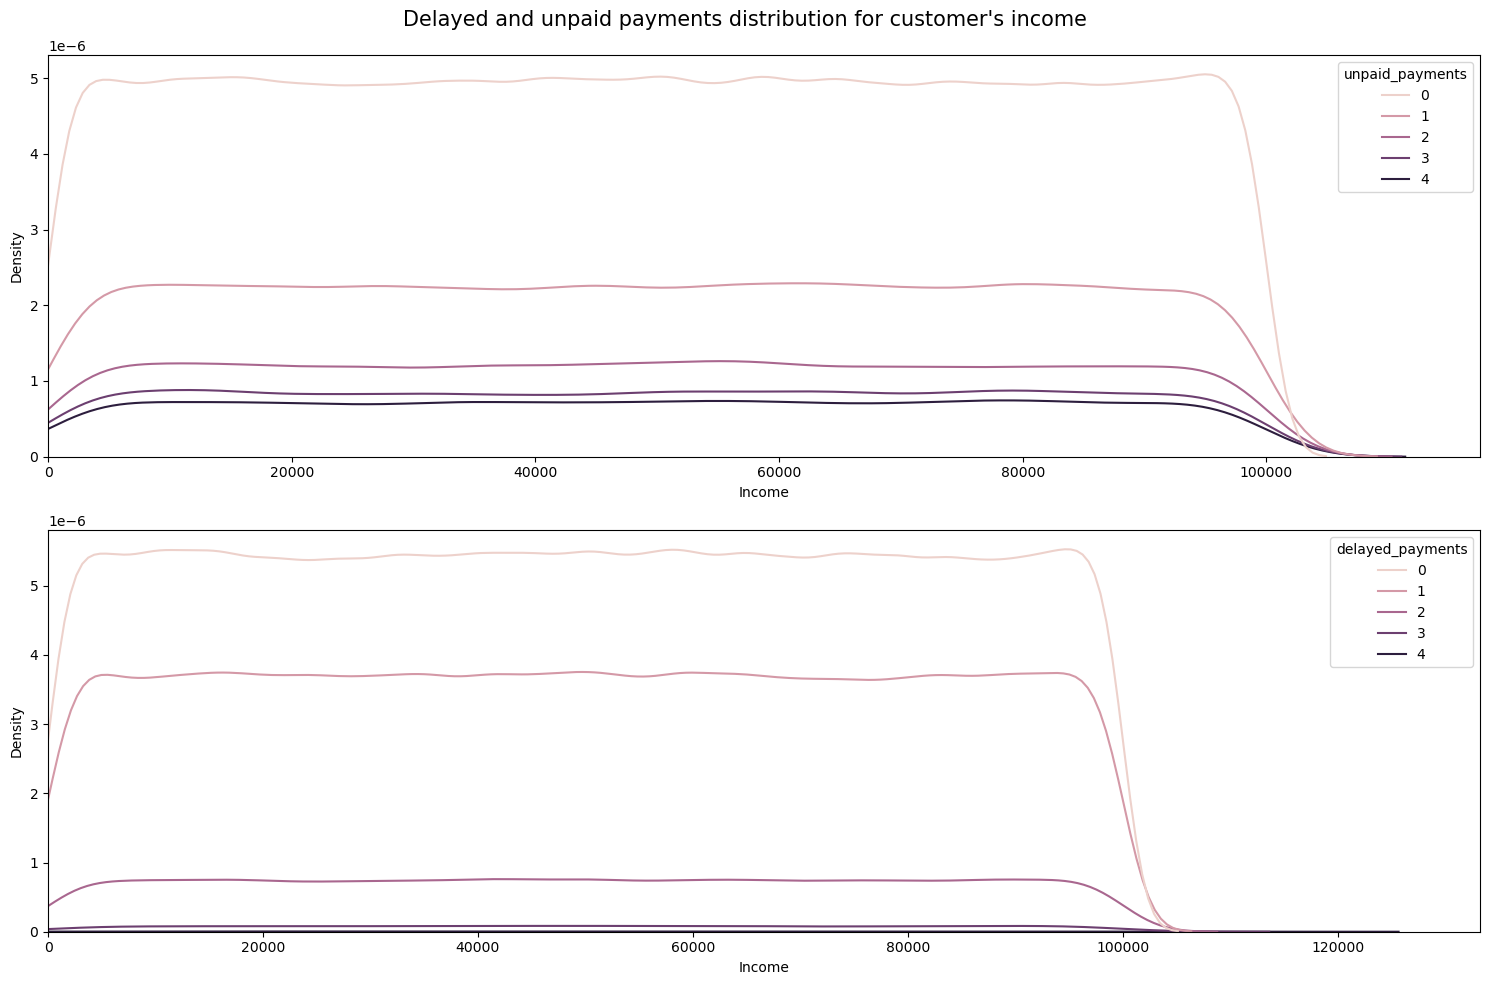

In [14]:
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))

sns.kdeplot(
    ax=ax0,
    data=transactions_facts_plot,
    x='income',
    hue='unpaid_payments',
    weights='unpaid_weight'
)

sns.kdeplot(
    ax=ax1,
    data=transactions_facts_plot,
    x='income',
    hue='delayed_payments',
    weights='delayed_weight'
)

ax0.set_xlabel('Income')
ax0.set_xlim(0)
ax1.set_xlabel('Income')
ax1.set_xlim(0)

fig.suptitle('Delayed and unpaid payments distribution for customer\'s income', fontsize=15)
fig.tight_layout()

plt.show()

The distribution is uniform, so income has no effect on customers behavior.

### Age

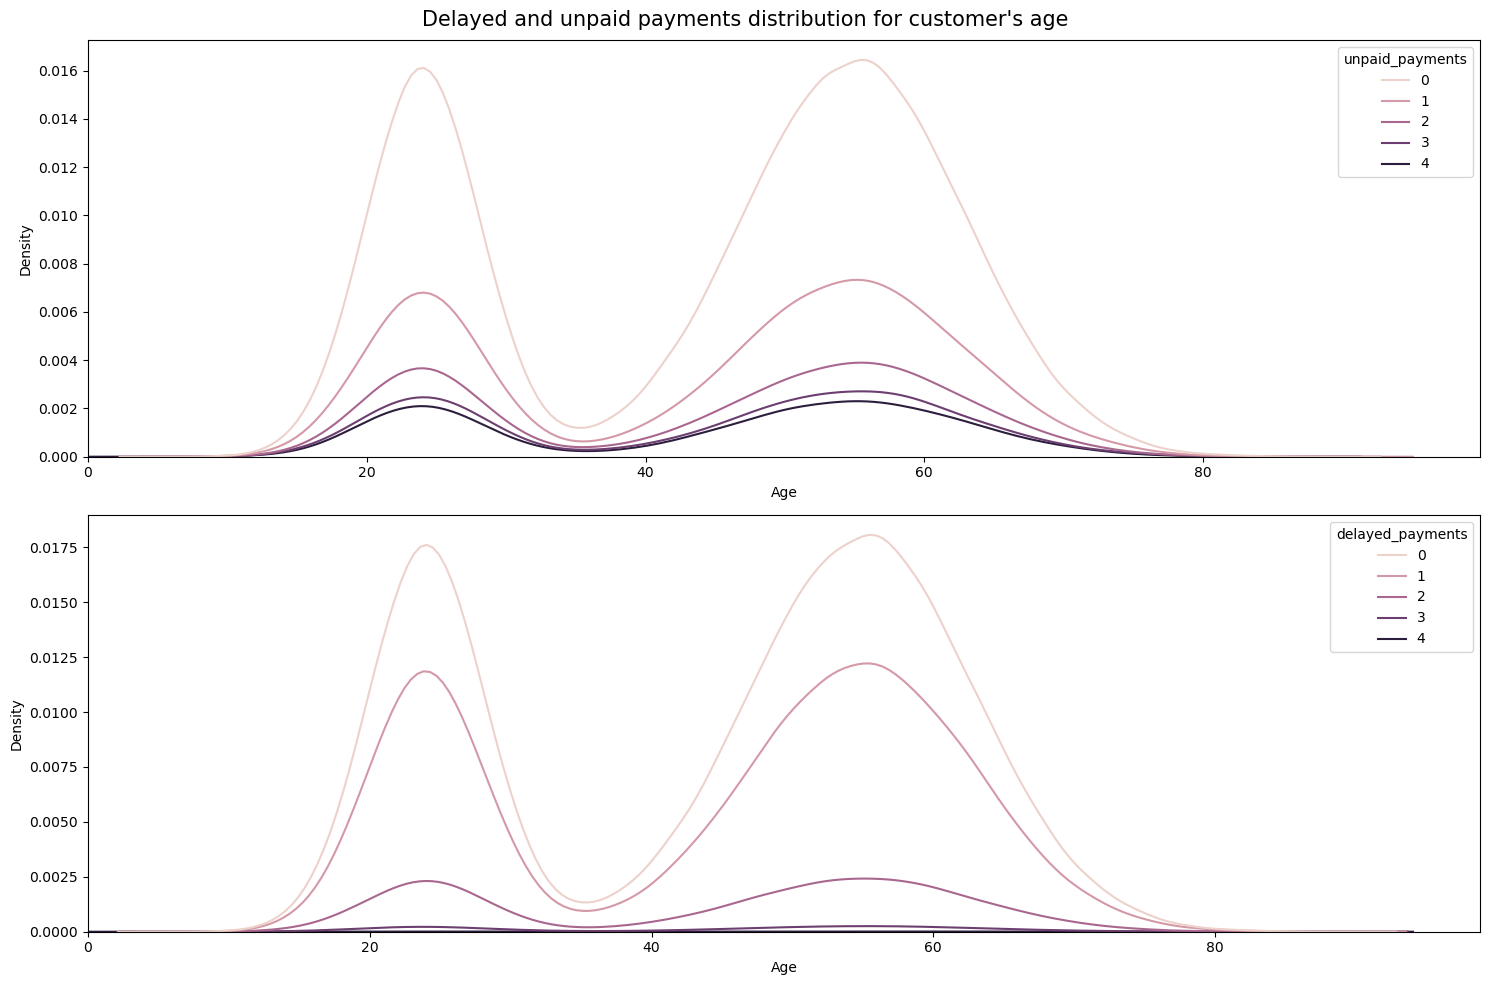

In [13]:
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))

sns.kdeplot(
    ax=ax0,
    data=transactions_facts_plot,
    x='age',
    hue='unpaid_payments',
    weights='unpaid_weight'
)

sns.kdeplot(
    ax=ax1,
    data=transactions_facts_plot,
    x='age',
    hue='delayed_payments',
    weights='delayed_weight'
)

ax0.set_xlabel('Age')
ax0.set_xlim(0)
ax1.set_xlabel('Age')
ax1.set_xlim(0)

fig.suptitle('Delayed and unpaid payments distribution for customer\'s age', fontsize=15)
fig.tight_layout()

plt.show()

Distributions have their maximums in the same place on x axis which means possibility of improper payment is not correlated to age. Although even if I wanted to take variables like age or sex into the model I would first check whether it violates law of the country that the service ran in.

### Price to income ratio

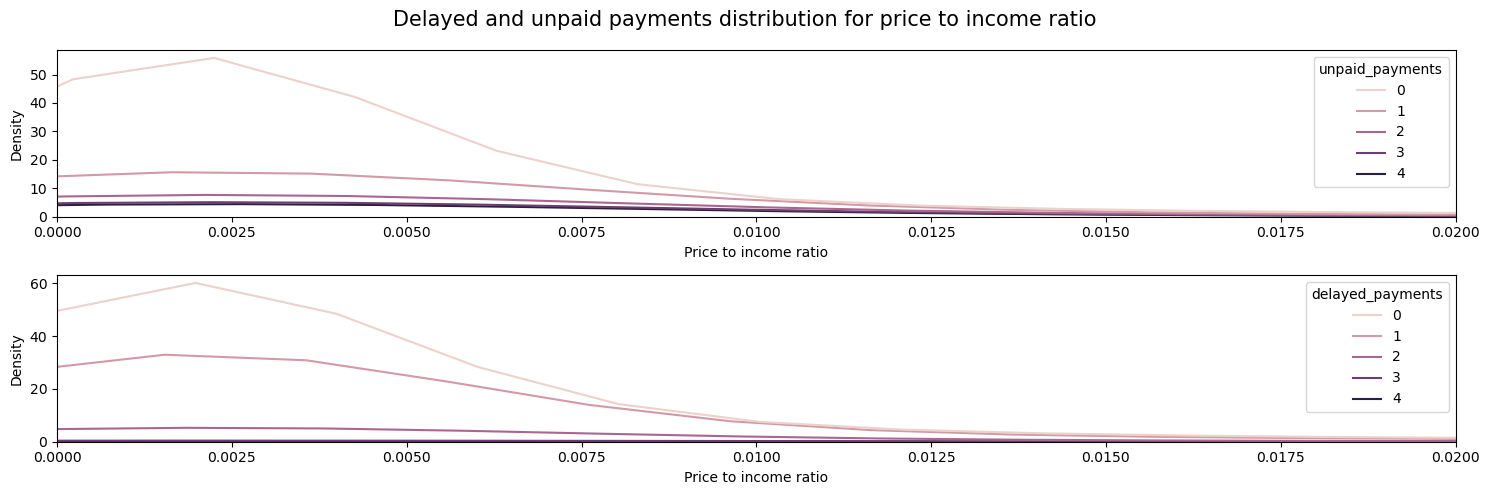

In [30]:
transactions_facts_2 = transactions_facts_plot.copy()
transactions_facts_2['price_income_rate'] = transactions_facts_2['price'] / transactions_facts_2['income']

fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(15,5))

sns.kdeplot(
    ax=ax0,
    data=transactions_facts_2,
    x='price_income_rate',
    hue='unpaid_payments',
    weights='unpaid_weight',
    gridsize=1000
)

sns.kdeplot(
    ax=ax1,
    data=transactions_facts_2,
    x='price_income_rate',
    hue='delayed_payments',
    weights='delayed_weight',
    gridsize=1000
)

ax0.set_xlabel('Price to income ratio')
ax0.set_xlim(0, 0.02)
ax1.set_xlabel('Price to income ratio')
ax1.set_xlim(0, 0.02)

fig.suptitle('Delayed and unpaid payments distribution for price to income ratio', fontsize=15)
fig.tight_layout()

plt.show()

Distributions of price to income ratio are similar for transactions which were paid on time to those that were not. That means this factor does not count.

### Looking for risky shops

For this point I will transform the dataset aggregating it by shops.

In [143]:
# Create columns for delayed payments data
shops_facts_delayed = transactions_facts[transactions_facts['delayed_payments'] > 0].groupby('shopID').agg(
    transactions_count_delayed=('transactionID', 'nunique'),
    transactions_sum_delayed=('price', 'sum')
).reset_index()
shops_facts_delayed['avg_price_delayed'] = shops_facts_delayed['transactions_sum_delayed'] / shops_facts_delayed['transactions_count_delayed']

# Create columns for unpaid payments data
shops_facts_unpaid = transactions_facts[transactions_facts['unpaid_payments'] > 0].groupby('shopID').agg(
    transactions_count_unpaid=('transactionID', 'nunique'),
    transactions_sum_unpaid=('price', 'sum')
).reset_index()
shops_facts_unpaid['avg_price_unpaid'] = shops_facts_unpaid['transactions_sum_unpaid'] / shops_facts_unpaid['transactions_count_unpaid']

# Create columns for all payments data
shops_facts = transactions_facts.copy().groupby('shopID').agg(
    transactions_count=('transactionID', 'nunique'),
    transactions_sum=('price', 'sum')
).reset_index()
shops_facts['avg_price'] = shops_facts['transactions_sum'] / shops_facts['transactions_count']

# Merge dataframes and fill NaNs
shops_facts = pd.merge(shops_facts, shops_facts_delayed, on='shopID', how='left')
shops_facts = pd.merge(shops_facts, shops_facts_unpaid, on='shopID', how='left')
shops_facts.fillna(0)

shops_facts['delayed_factor'] = shops_facts['transactions_count_delayed'] / shops_facts['transactions_count']
shops_facts['unpaid_factor'] = shops_facts['transactions_count_unpaid'] / shops_facts['transactions_count']

shops_facts.head()

,shopID,transactions_count,transactions_sum,avg_price,transactions_count_delayed,transactions_sum_delayed,avg_price_delayed,transactions_count_unpaid,transactions_sum_unpaid,avg_price_unpaid,delayed_factor,unpaid_factor
0,100,2240,226599,101.160268,682.0,70392.0,103.214076,191,19118,100.094241,0.304464,0.085268
1,101,2258,232228,102.846767,671.0,68757.0,102.469449,174,17388,99.931034,0.297166,0.077059
2,102,2343,237597,101.407170,711.0,72881.0,102.504923,247,25162,101.870445,0.303457,0.105420
3,103,2311,235595,101.945045,674.0,68235.0,101.238872,219,21799,99.538813,0.291649,0.094764
4,104,2224,223254,100.383993,632.0,65547.0,103.713608,216,20961,97.041667,0.284173,0.097122


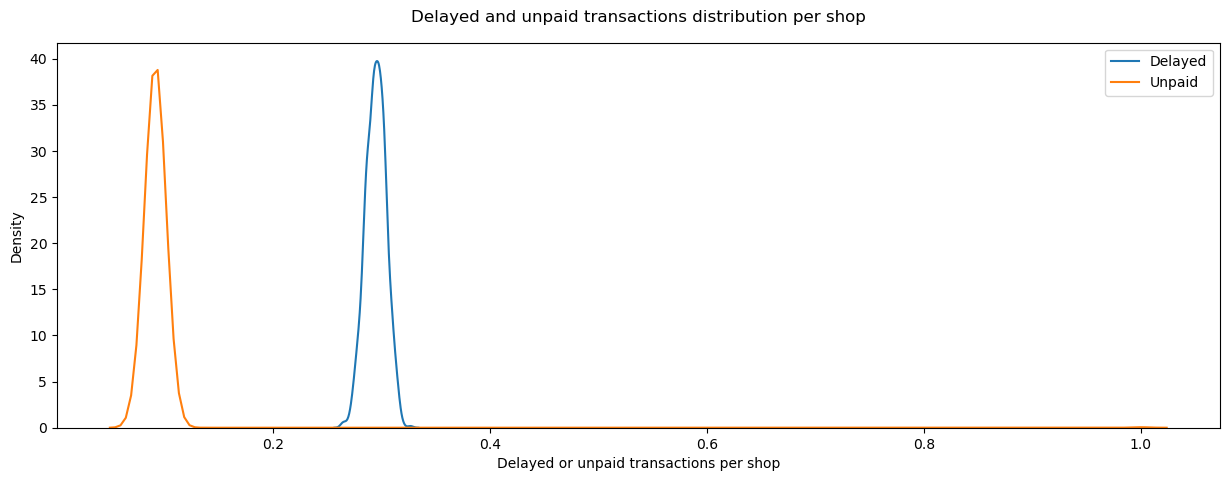

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

sns.kdeplot(
    ax=ax,
    data=shops_facts,
    x='delayed_factor',
    label='Delayed'
)
sns.kdeplot(
    ax=ax,
    data=shops_facts,
    x='unpaid_factor',
    label='Unpaid'
)

ax.legend()
ax.set_title('Delayed and unpaid transactions distribution per shop', pad=15)
ax.set_xlabel('Delayed or unpaid transactions per shop')

plt.show()

In [153]:
print('Most frequently delayed shops:\n', shops_facts[['shopID', 'delayed_factor']].sort_values('delayed_factor', ascending=False).head(), '\n')
print('Least frequently delayed shops:\n', shops_facts[['shopID', 'delayed_factor']].sort_values('delayed_factor', ascending=True).head(), '\n')
print('Most frequently unpaid shops:\n', shops_facts[['shopID', 'unpaid_factor']].sort_values('unpaid_factor', ascending=False).head(), '\n')
print('Least frequently unpaid shops:\n', shops_facts[['shopID', 'unpaid_factor']].sort_values('unpaid_factor', ascending=True).head(), '\n')

Most frequently delayed shops:
     shopID  delayed_factor
522    622        0.326386
892    992        0.319005
865    965        0.318123
731    831        0.316461
332    432        0.315596 

Least frequently delayed shops:
     shopID  delayed_factor
837    937        0.263541
467    567        0.264368
571    671        0.265188
642    742        0.267890
19     119        0.269797 

Most frequently unpaid shops:
     shopID  unpaid_factor
13     113       1.000000
350    450       0.108686
558    658       0.107866
523    623       0.107096
90     190       0.107080 

Least frequently unpaid shops:
     shopID  unpaid_factor
464    564       0.072958
344    444       0.074487
599    699       0.074805
630    730       0.074910
435    535       0.075231 



In [156]:
transactions_facts[transactions_facts['shopID']=='113']

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,delayed_payments,unpaid_payments
1701,1702,113,9169,9,2,2,2,2,1.0,75.0,23 Joffre Street,23 Joffre Street,95200.0,0,4
2530,2531,113,325418,122,2,2,2,2,1.0,79.0,30 View Street,30 View Street,84900.0,0,4
3567,3568,113,457004,123,2,2,2,2,1.0,52.0,54 Eren Court,54 Eren Court,43500.0,0,4
4577,4578,113,93714,70,2,2,2,2,1.0,45.0,31 Theale Terrace,31 Theale Terrace,24800.0,0,4
4723,4724,113,177400,96,2,2,2,2,2.0,20.0,95 Percy Street,,95300.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995352,1995353,113,337672,80,2,2,2,2,1.0,56.0,7 Caladenia Street,7 Caladenia Street,70100.0,0,4
1996060,1996061,113,120027,180,2,2,2,2,1.0,19.0,79 Banks Street,79 Banks Street,65100.0,0,4
1998490,1998491,113,287125,34,2,2,2,2,1.0,36.0,19 Thomas Street,19 Thomas Street,12100.0,0,4
1998904,1998905,113,419778,180,2,2,2,2,2.0,23.0,87 Lilley Street,87 Lilley Street,68000.0,0,4


In [157]:
shops_facts[shops_facts['shopID']=='113']

,shopID,transactions_count,transactions_sum,avg_price,transactions_count_delayed,transactions_sum_delayed,avg_price_delayed,transactions_count_unpaid,transactions_sum_unpaid,avg_price_unpaid,delayed_factor,unpaid_factor
13,113,2256,227843,100.994238,NaN,NaN,NaN,2256,227843,100.994238,NaN,1.0


We must avoid shop number 113 - it has never been paid! Frequency of delays and refusals to pay in other shops show normal distribution.

### Looking for risky customers

Creating the next dataframe, this time aggregated to the customers.

In [22]:
# Create columns for delayed payments data
customers_facts_delayed = transactions_facts[transactions_facts['delayed_payments'] > 0]\
                            .copy()\
                            .dropna(subset='customerID')\
                            .groupby('customerID')\
                            .agg(
                                transactions_count_delayed=('transactionID', 'nunique'),
                                transactions_sum_delayed=('price', 'sum')
).reset_index()

# Create columns for unpaid payments data
customers_facts_unpaid = transactions_facts[transactions_facts['unpaid_payments'] > 0]\
                            .copy()\
                            .dropna(subset='customerID')\
                            .groupby('customerID')\
                            .agg(
                                transactions_count_unpaid=('transactionID', 'nunique'),
                                transactions_sum_unpaid=('price', 'sum')
).reset_index()

# Create columns for all payments data
customers_facts = transactions_facts.copy().dropna(subset='customerID').groupby('customerID').agg(
    transactions_count=('transactionID', 'nunique'),
    transactions_sum=('price', 'sum')
).reset_index()

# Merge dataframes and fill NaNs
customers_facts = pd.merge(customers_facts, customers_facts_delayed, on='customerID', how='left')
customers_facts = pd.merge(customers_facts, customers_facts_unpaid, on='customerID', how='left')
customers_facts = customers_facts.fillna(0)

customers_facts['delayed_factor'] = customers_facts['transactions_count_delayed'] / customers_facts['transactions_count']
customers_facts['unpaid_factor'] = customers_facts['transactions_count_unpaid'] / customers_facts['transactions_count']

customers_facts.head()

,customerID,transactions_count,transactions_sum,transactions_count_delayed,transactions_sum_delayed,transactions_count_unpaid,transactions_sum_unpaid,delayed_factor,unpaid_factor
0,1.0,4,505,1.0,177.0,0.0,0.0,0.250000,0.000000
1,2.0,7,749,2.0,226.0,0.0,0.0,0.285714,0.000000
2,3.0,9,921,1.0,115.0,1.0,66.0,0.111111,0.111111
3,4.0,1,136,1.0,136.0,0.0,0.0,1.000000,0.000000
4,5.0,5,470,2.0,168.0,2.0,121.0,0.400000,0.400000


In [24]:
print(customers_facts['transactions_count_delayed'].value_counts(), '\n\n')
print(customers_facts['transactions_count_unpaid'].value_counts(), '\n\n')

transactions_count_delayed
0.0     180046
1.0     148889
2.0      90574
3.0      44161
4.0      17914
5.0       6393
6.0       1895
7.0        510
8.0        119
9.0         28
11.0         2
10.0         2
Name: count, dtype: int64 


transactions_count_unpaid
0.0     356967
1.0     100253
2.0      23696
3.0       6156
4.0       2068
5.0        826
6.0        360
7.0        141
8.0         42
9.0         16
10.0         7
11.0         1
Name: count, dtype: int64 




In [206]:
print('Customers with the most delays:\n', customers_facts[['customerID', 'transactions_count_delayed', 'delayed_factor']]\
                      .sort_values('transactions_count_delayed', ascending=False).head(), '\n\n')
print('Customers with the most refusals to pay:\n', customers_facts[['customerID', 'transactions_count_unpaid', 'unpaid_factor']]\
                      .sort_values('transactions_count_unpaid', ascending=False).head(), '\n\n')

Customers with the most delays:
         customerID  transactions_count_delayed  delayed_factor
48037      48949.0                        11.0        0.916667
179473    182906.0                        11.0        0.846154
274879    280145.0                        10.0        0.833333
325991    332224.0                        10.0        0.909091
281890    287285.0                         9.0        0.900000 


Customers with the most refusals to pay:
         customerID  transactions_count_unpaid  unpaid_factor
234023    238503.0                       11.0       0.916667
205602    209549.0                       10.0       1.000000
13388      13667.0                       10.0       1.000000
453220    461945.0                       10.0       1.000000
274300    279558.0                       10.0       0.909091 




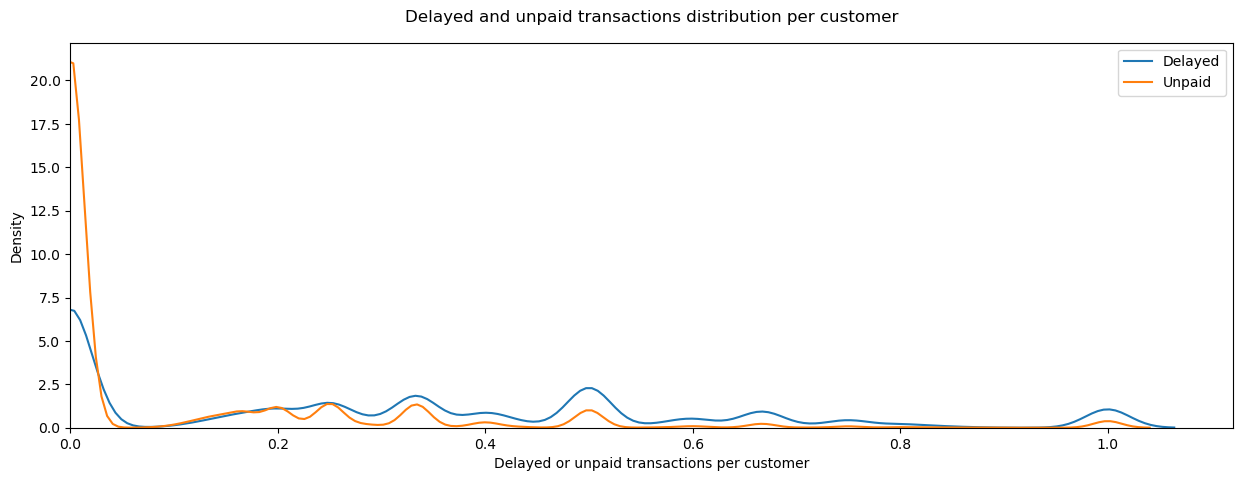

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

sns.kdeplot(
    ax=ax,
    data=customers_facts,
    x='delayed_factor',
    label='Delayed'
)
sns.kdeplot(
    ax=ax,
    data=customers_facts,
    x='unpaid_factor',
    label='Unpaid'
)

ax.legend()
ax.set_title('Delayed and unpaid transactions distribution per customer', pad=15)
ax.set_xlabel('Delayed or unpaid transactions per customer')
ax.set_xlim(0)

plt.show()

Majority of customers has no unpaid payments, but less of them have no delays. Other values are quite evenly distributed, which may be useful during modelling. Both unpaid and delay ratio, as well as number of transactions should be helpful.

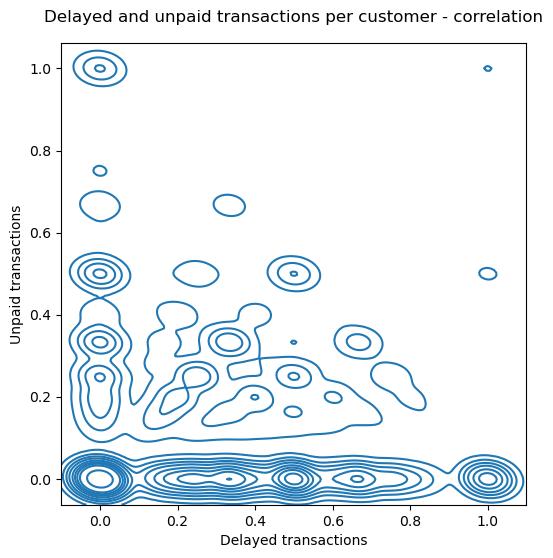

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

sns.kdeplot(
    ax=ax,
    data=customers_facts,
    x='delayed_factor',
    y='unpaid_factor'
)

ax.set_title('Delayed and unpaid transactions per customer - correlation', pad=15)
ax.set_xlabel('Delayed transactions')
ax.set_ylabel('Unpaid transactions')

plt.show()

There is no correlation between unpaid and delayed transactions ratio. This chart confirms that most customers have no unpaid transactions.

### First transaction per customer

Let's check if there is any rule for the first order for the customer. This would be needed for the customers that we don't have any historical payments to predict on.

In [221]:
transactions_first = transactions_facts.groupby('customerID').agg(
    transactionID=('transactionID', 'min')
).reset_index()

In [222]:
transactions_first.head()

,customerID,transactionID
0,1,119294
1,2,983409
2,3,293501
3,4,1536291
4,5,336269


In [228]:
transactions_first_facts = pd.merge(transactions_facts.copy(), transactions_first['transactionID'], on='transactionID', how='inner')

transactions_first_facts.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,delayed_payments,unpaid_payments
0,1,114,2869,140,0,0,0,0,2.0,24.0,74 Ada Street,74 Ada Street,54900.0,0,0
1,2,855,124077,70,0,0,0,0,1.0,46.0,23 Brampton Street,23 Brampton Street,60000.0,0,0
2,3,752,86184,85,0,0,0,0,1.0,52.0,96 Avon Street,35 Spurwood Street,7100.0,0,0
3,4,246,248861,43,1,0,0,0,1.0,29.0,3 Merinda Street,3 Merinda Street,67600.0,1,0
4,5,973,162112,127,0,0,0,0,2.0,30.0,64 Distribution Street,64 Distribution Street,92000.0,0,0


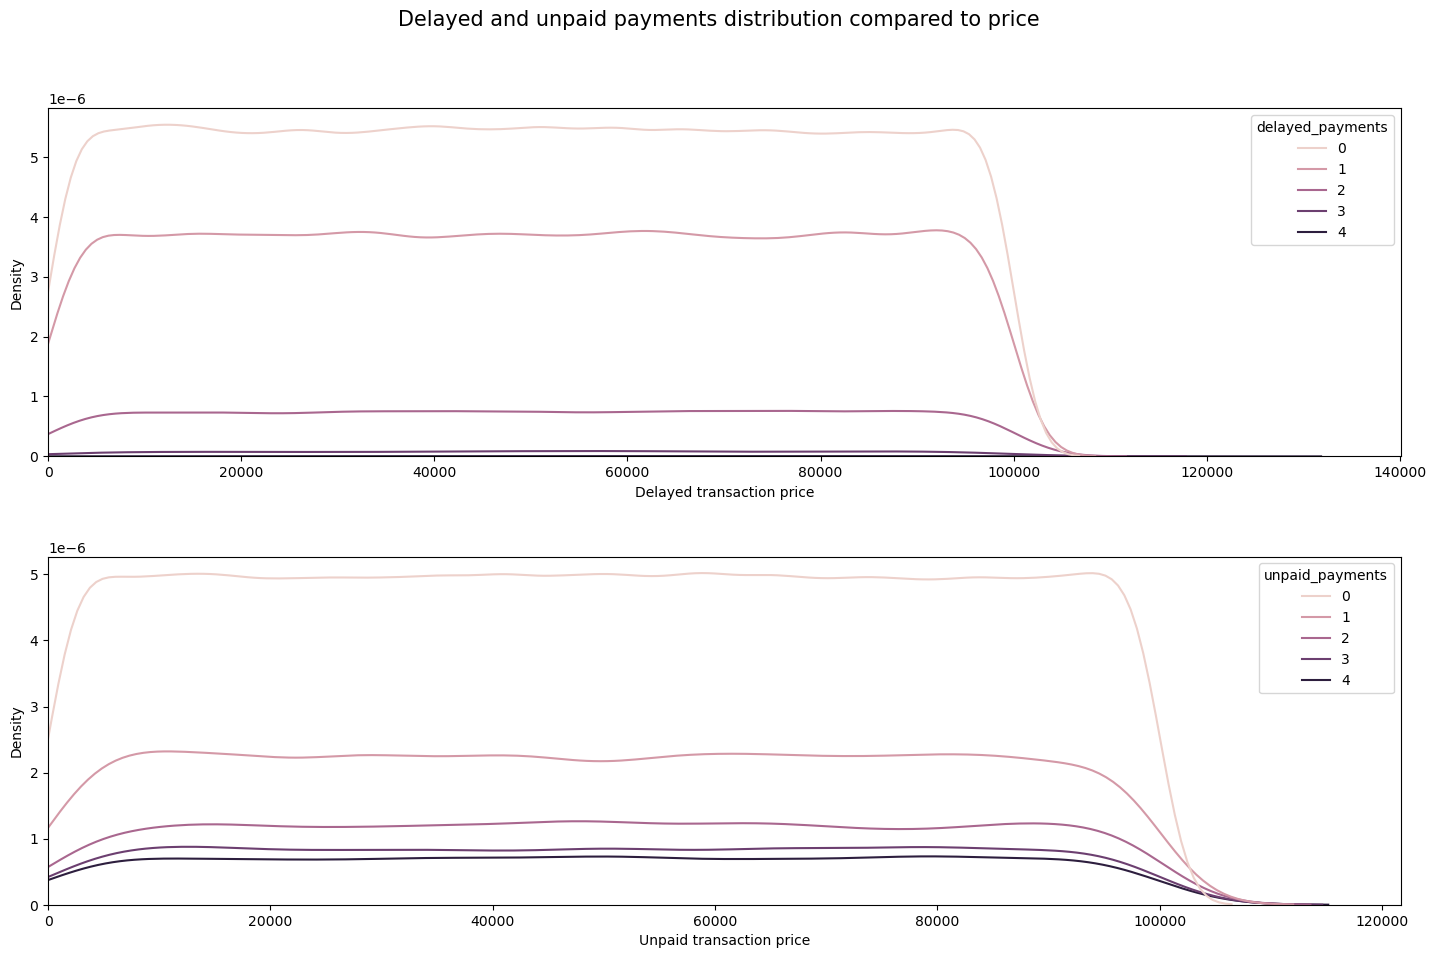

In [231]:
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))

transactions_first_facts_plot = transactions_first_facts.copy()
transactions_first_facts_plot['delayed_weight'] = np.where(transactions_first_facts_plot['delayed_payments'] == 0, 0.5, 1)
transactions_first_facts_plot['unpaid_weight'] = np.where(transactions_first_facts_plot['unpaid_payments'] == 0, 0.1, 1)

sns.kdeplot(
    ax=ax0,
    data=transactions_first_facts_plot,
    x='income',
    hue='delayed_payments',
    weights='delayed_weight'
)

sns.kdeplot(
    ax=ax1,
    data=transactions_first_facts_plot,
    x='income',
    hue='unpaid_payments',
    weights='unpaid_weight'
)

ax0.set_xlabel('Delayed transaction price')
ax1.set_xlabel('Unpaid transaction price')
ax0.set_xlim(0)
ax1.set_xlim(0)

fig.suptitle('Delayed and unpaid payments distribution compared to price', fontsize=15)
fig.tight_layout(pad=3)

plt.show()

Distributions for the first transaction are the same as for the others so it doesn't matter wether we look at the first or consecutive customer's transaction. 

### Address

Customers usually have the same postal and residential address, but sometimes postal address is missing or they differ. Let's check if it has impact on their ratio of unpaid transactions

In [244]:
transactions_facts_address = transactions_facts.copy()
transactions_facts_address = transactions_facts_address.dropna(subset='customerID')

conditions = [
    transactions_facts_address['postalAddress'] == '',
    (transactions_facts_address['postalAddress'] != '') & (transactions_facts_address['postalAddress'] != transactions_facts_address['residentialAddress']),
    transactions_facts_address['postalAddress'] == transactions_facts_address['residentialAddress']
]
address_status = [
    'postal address missing',
    'different addresses',
    'same addresses'
]
transactions_facts_address['address_status'] = np.select(conditions, address_status)
transactions_facts_address = pd.merge(transactions_facts_address, customers_facts, how='left', on='customerID')

transactions_facts_address.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,...,unpaid_payments,address_status,transactions_count,transactions_sum,transactions_count_delayed,transactions_sum_delayed,transactions_count_unpaid,transactions_sum_unpaid,delayed_factor,unpaid_factor
0,1,114,2869.0,140,0,0,0,0,2.0,24.0,...,0,same addresses,4,504,1.0,39.0,0.0,0.0,0.25,0.000000
1,2,855,124077.0,70,0,0,0,0,1.0,46.0,...,0,same addresses,4,281,0.0,0.0,1.0,28.0,0.00,0.250000
2,3,752,86184.0,85,0,0,0,0,1.0,52.0,...,0,different addresses,7,500,0.0,0.0,1.0,10.0,0.00,0.142857
3,4,246,248861.0,43,1,0,0,0,1.0,29.0,...,0,same addresses,3,309,3.0,309.0,0.0,0.0,1.00,0.000000
4,5,973,162112.0,127,0,0,0,0,2.0,30.0,...,0,same addresses,5,564,0.0,0.0,0.0,0.0,0.00,0.000000


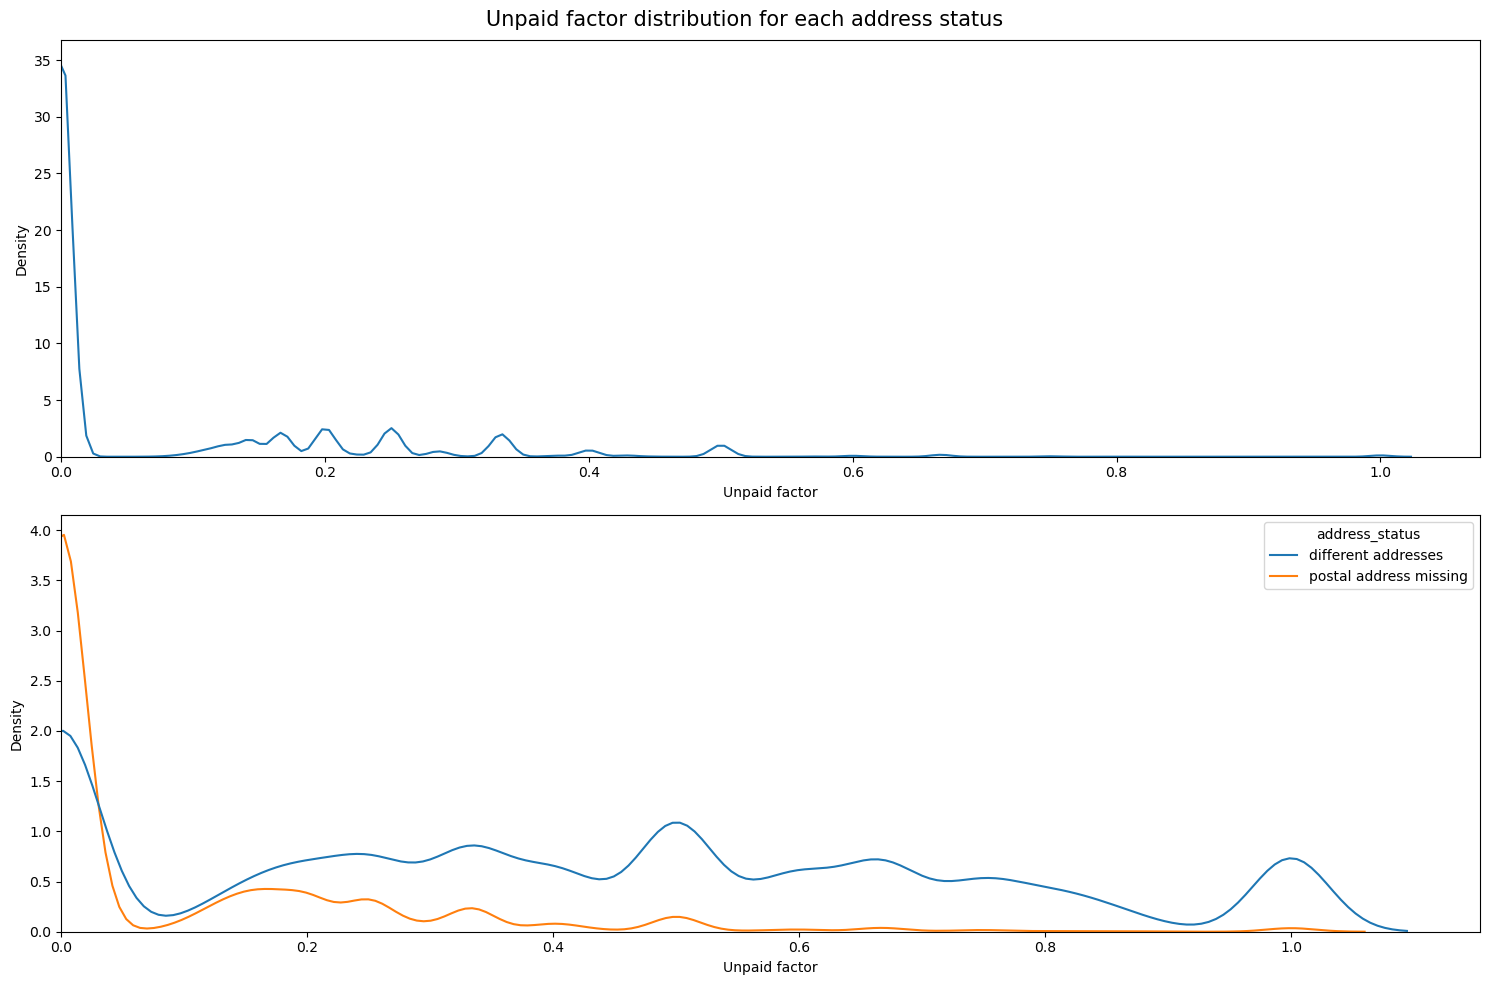

In [245]:
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(15,10))

sns.kdeplot(
    ax=ax0,
    data=transactions_facts_address[transactions_facts_address['address_status'] == 'same addresses'],
    x='unpaid_factor',
)
sns.kdeplot(
    ax=ax1,
    data=transactions_facts_address[transactions_facts_address['address_status'] != 'same addresses'],
    x='unpaid_factor',
    hue='address_status',
)

ax0.set_xlabel('Unpaid factor')
ax0.set_xlim(0)
ax1.set_xlabel('Unpaid factor')
ax1.set_xlim(0)

fig.suptitle('Unpaid factor distribution for each address status', fontsize=15)
fig.tight_layout()

plt.show()

In [246]:
transactions_facts_address.groupby('address_status')['unpaid_factor'].describe()

,count,mean,std,min,25%,50%,75%,max
address_status,,,,,,,,
different addresses,97142.0,0.407321,0.312228,0.0,0.142857,0.4,0.666667,1.0
postal address missing,40051.0,0.090984,0.166019,0.0,0.000000,0.0,0.166667,1.0
same addresses,1842790.0,0.075435,0.138522,0.0,0.000000,0.0,0.142857,1.0


We can see that people with different postal and residential addresses are less reliable when it comes to payments. Their mean unpaid factor is 40%, while for other groups it is less than 10%.

## Task 4
We want to send adequate marketing communication to customer – propose customers 
segments that we could use when we want to send emails with offers

Looking at the data above I would propose such groups:
 - Customers who are usually late with payments - reminder on the payment deadline,
 - I assume instead of data provided for this task you also keep dates of customers activites. I think communication to the customers who don't use the service for long time as a reminder could be helpful,
 - Customers who tend to buy products in particular time of the year - like before Christmas or Valentine's day - offer or reminder in this time,
 - Customers with highest rate of payments on time - email like "Great job! You are at the top in staying on track with payments! See you next time!" - maybe it sounds a bit SPAMish, but this could also build customer's self-confidence, thus making the brand associated with good feelings,
 - Some kind of recommendation tool - basing on choices of other customers "It may interest you" message could be deployed.

## Task 5
Perform exploratory data analysis (EDA) and present interesting findings related to credit risk

Based on the analysis from above I have found following facts:
 - Neither product's price, customer's income nor age have effect on the frequency of missed/delayed payments,
 - There are normal distributions of delayed and unpaid payments ratios with one solid outlier - a shop which has never been paid among over 2200 transactions,
 - Customers have different behaviors if it comes to payment reliability and there is no visible correlation between frequencies of unpaid and delayed transactions,
 - Price of the product does not affect performance of the first transaction of the customer - that means we can not use it to predict customer's first behavior.
 - Both unpaid and delayed transactions are minor groups (around 10% and 30% frequency) and it should be taken into consideration while training the model
 - Customers with different postal and residential addresses tend to complete payments less frequently.

## Task 6
Build model/models that predict if customer will not pay back the loan

To build the model I will conduct a bit of data engineering first. I will prepare new datasets based on transactions_facts.

In [42]:
transactions_facts.head()

,transactionID,shopID,customerID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,delayed_payments,unpaid_payments
0,1,114,2869.0,140,0,0,0,0,2.0,24.0,74 Ada Street,74 Ada Street,54900.0,0,0
1,2,855,124077.0,70,0,0,0,0,1.0,46.0,23 Brampton Street,23 Brampton Street,60000.0,0,0
2,3,752,86184.0,85,0,0,0,0,1.0,52.0,96 Avon Street,35 Spurwood Street,7100.0,0,0
3,4,246,248861.0,43,1,0,0,0,1.0,29.0,3 Merinda Street,3 Merinda Street,67600.0,1,0
4,5,973,162112.0,127,0,0,0,0,2.0,30.0,64 Distribution Street,64 Distribution Street,92000.0,0,0


Columns that will let us split the data

In [43]:
transactions_last = transactions_facts.copy()\
                                    .dropna(subset='customerID')\
                                    .groupby('customerID')\
                                    .agg(transactionID=('transactionID', 'max'))\
                                    .reset_index()
transactions_last['is_last'] = 1
transactions_last.head()

,customerID,transactionID,is_last
0,1.0,1697842,1
1,2.0,1834257,1
2,3.0,1974624,1
3,4.0,1536291,1
4,5.0,661121,1


In [249]:
transactions_model = pd.merge(transactions_facts.copy(), transactions_last, how='left', on=['customerID', 'transactionID'])
transactions_model['is_last'] = transactions_model['is_last'].fillna(0)
transactions_model['is_unpaid'] = np.where(transactions_model['unpaid_payments'] > 0, 1, 0)
condition = [(transactions_model['postalAddress'] != '') & (transactions_model['postalAddress'] != transactions_model['residentialAddress'])]
transactions_model['different_addr'] = np.select(condition, [1])
transactions_model = transactions_model.drop(columns=['transactionID', 
                                                       'price', 
                                                       'sex', 
                                                       'age', 
                                                       'residentialAddress', 
                                                       'postalAddress',
                                                       'income',
                                                       'delayed_payments',
                                                       'unpaid_payments',
                                                       'paytmentStatus1',
                                                       'paytmentStatus2',
                                                       'paytmentStatus3',
                                                       'paytmentStatus4'])
transactions_model.head()

,shopID,customerID,is_last,is_unpaid,different_addr
0,114,2869.0,0.0,0,0
1,855,124077.0,0.0,0,0
2,752,86184.0,0.0,0,1
3,246,248861.0,0.0,0,0
4,973,162112.0,0.0,0,0


### Calculating features
Now, in the training set we can not use data from prediction set, so we have to calculate the ratios for customers and shops again.

In [58]:
# Shops
shops_model = transactions_model[transactions_model['is_last']==0]\
                .groupby('shopID')\
                .agg(
                    transactions_count=('shopID', 'size'),
                    unpaid_sum=('is_unpaid', 'sum')
).reset_index()
shops_model['shop_unpaid_ratio'] = shops_model['unpaid_sum'] / shops_model['transactions_count']

shops_model.head()

,shopID,transactions_count,unpaid_sum,shop_unpaid_ratio
0,100,1693,143,0.084465
1,101,1728,143,0.082755
2,102,1766,187,0.105889
3,103,1744,162,0.092890
4,104,1655,156,0.094260


In [67]:
# Customers
customers_model = transactions_model[transactions_model['is_last']==0]\
                .dropna(subset='customerID')\
                .groupby('customerID')\
                .agg(
                    customer_transactions_count=('shopID', 'size'),
                    unpaid_sum=('is_unpaid', 'sum')
).reset_index()
customers_model['customer_unpaid_ratio'] = customers_model['unpaid_sum'] / customers_model['customer_transactions_count']

customers_model.head()

,customerID,customer_transactions_count,unpaid_sum,customer_unpaid_ratio
0,1.0,3,0,0.000
1,2.0,6,0,0.000
2,3.0,8,1,0.125
3,5.0,4,2,0.500
4,6.0,2,0,0.000


Now we can join calculated columns to the main dataset

In [250]:
transactions_model = pd.merge(transactions_model, shops_model[['shopID', 'shop_unpaid_ratio']], how='left', on='shopID')
transactions_model = pd.merge(transactions_model, customers_model[['customerID', 'customer_transactions_count', 'customer_unpaid_ratio']], how='left', on='customerID')
transactions_model = transactions_model.dropna(subset='customerID') # drop from the training set rows with missing customer
transactions_model = transactions_model.fillna(0)

transactions_model.head()

,shopID,customerID,is_last,is_unpaid,different_addr,shop_unpaid_ratio,customer_transactions_count,customer_unpaid_ratio
0,114,2869.0,0.0,0,0,0.094493,3.0,0.000000
1,855,124077.0,0.0,0,0,0.104960,3.0,0.333333
2,752,86184.0,0.0,0,1,0.104567,6.0,0.000000
3,246,248861.0,0.0,0,0,0.087060,2.0,0.000000
4,973,162112.0,0.0,0,0,0.088993,4.0,0.000000


In [251]:
transactions_model.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1979983 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   shopID                       1979983 non-null  object 
 1   customerID                   1979983 non-null  float64
 2   is_last                      1979983 non-null  float64
 3   is_unpaid                    1979983 non-null  int32  
 4   different_addr               1979983 non-null  int32  
 5   shop_unpaid_ratio            1979983 non-null  float64
 6   customer_transactions_count  1979983 non-null  float64
 7   customer_unpaid_ratio        1979983 non-null  float64
dtypes: float64(5), int32(2), object(1)
memory usage: 120.8+ MB


### Splitting data
We will take last transactions as validation set and the other ones will serve as training and testing data. Knowing from EDA that unpaid transactions are a minor group and there are a lot of observations we will also undersample the training set.

In [252]:
variables = ['shop_unpaid_ratio', 'customer_transactions_count', 'customer_unpaid_ratio', 'different_addr']

In [253]:
X_validate = transactions_model[transactions_model['is_last']==1][variables]
X_validate.head()

,shop_unpaid_ratio,customer_transactions_count,customer_unpaid_ratio,different_addr
75,0.097502,0.0,0.0,0
112,0.087402,0.0,0.0,0
158,0.090234,0.0,0.0,0
176,0.086002,0.0,0.0,0
180,0.085253,0.0,0.0,0


In [254]:
y_validate = transactions_model[transactions_model['is_last']==1][['is_unpaid']]
y_validate.head()

,is_unpaid
75,0
112,0
158,0
176,0
180,0


In [255]:
X_train, X_test, y_train, y_test = train_test_split(
    transactions_model[transactions_model['is_last']==0][variables],
    transactions_model[transactions_model['is_last']==0][['is_unpaid']],
    test_size=0.3,
    random_state=123
)

Let's check whether tha target variable is evenly distributed in the subsets

In [256]:
print('Train:\n', y_train.value_counts(), '\n')
print('Test:\n', y_test.value_counts(), '\n')
print('Validate:\n', y_validate.value_counts(), '\n')

Train:
 is_unpaid
0            946607
1             96008
Name: count, dtype: int64 

Test:
 is_unpaid
0            405745
1             41090
Name: count, dtype: int64 

Validate:
 is_unpaid
0            445408
1             45125
Name: count, dtype: int64 



In all subsets there is around 9% of unpaid transactions, so they are distributed evenly. Having a deeper look inside type of shops would let us perform stratified sampling which would also be desirable. Imbalance in target class counts also means we will not use accuracy as metric. Assuming unpaid transactions cause lost income we will use recall to minimize false negatives. Now we can undersample the training set.

In [257]:
train = pd.concat([X_train, y_train], axis=1)
train_undersampled = pd.concat([
    train[train['is_unpaid']==0].sample(frac=0.3),
    train[train['is_unpaid']==1]
    ], ignore_index=True
)
train_undersampled['is_unpaid'].value_counts()

is_unpaid
0    283982
1     96008
Name: count, dtype: int64

In [258]:
X_train_u = train_undersampled[variables]
y_train_u = train_undersampled['is_unpaid']

### Baseline model - logistic regression
We will use this model as this is usually proper choice for binary classification tasks.

In [261]:
log_reg = LogisticRegression(max_iter=200)
param_grid = [
{
    'C': [0.01, 0.1, 1],
    'penalty': ['l2'],
    'solver': ['newton-cholesky', 'saga', 'liblinear']
},
{
    'C': [0.01, 0.1, 1],
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga']
}]

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

In [262]:
grid_search.fit(X_train_u, y_train_u)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                          'solver': ['newton-cholesky', 'saga', 'liblinear']},
                         {'C': [0.01, 0.1, 1], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']}],
             scoring='recall')

Now let's assign the best model parameters to the model defined before and check its performance.

In [264]:
log_reg = grid_search.best_estimator_
y_pred = log_reg.predict(X_test)
print('Results of prediction:\n', classification_report(y_test, y_pred))

Results of prediction:
               precision    recall  f1-score   support

           0       0.97      0.93      0.94    405745
           1       0.48      0.67      0.56     41090

    accuracy                           0.90    446835
   macro avg       0.72      0.80      0.75    446835
weighted avg       0.92      0.90      0.91    446835



Let's show the performance on the ROC curve which tell us how dynamic what TPR and FPR would there be for different classification thresholds.

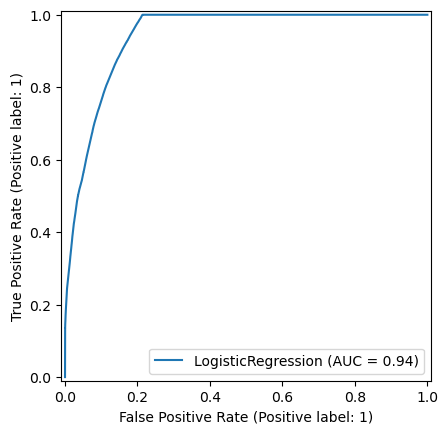

In [265]:
y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
log_reg_roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds
})

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.show()

In [266]:
log_reg_roc_df.head()

,fpr,tpr,thresholds
0,0.0,0.000000,inf
1,0.0,0.000024,1.000000
2,0.0,0.000170,1.000000
3,0.0,0.000681,1.000000
4,0.0,0.000876,0.999999


Small changes of FPR would cause rapid changes of TPR. Exact values can be taken from log_reg_roc_df. Don't be surprised by high AUC score, as it is easier to achieve for imbalanced classes.

### Random forest

In [267]:
ran_for = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'class_weight': [None, 'balanced']
}
#
grid_search = GridSearchCV(
    estimator=ran_for,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

In [268]:
grid_search.fit(X_train_u, y_train_u)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 5], 'n_estimators': [100, 200]},
             scoring='recall')

In [269]:
ran_for = grid_search.best_estimator_
y_pred = ran_for.predict(X_test)
print('Results of prediction:\n', classification_report(y_test, y_pred))

Results of prediction:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88    405745
           1       0.32      1.00      0.49     41090

    accuracy                           0.81    446835
   macro avg       0.66      0.89      0.68    446835
weighted avg       0.94      0.81      0.84    446835



### Gradient boosting

In [270]:
grad_b = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 3],
    'learning_rate': [0.03, 0.1, 0.25]
}

grid_search = GridSearchCV(
    estimator=grad_b,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

In [271]:
grid_search.fit(X_train_u, y_train_u)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.1, 0.25],
                         'max_depth': [2, 3], 'n_estimators': [100, 200]},
             scoring='recall')

In [272]:
grad_b = grid_search.best_estimator_
y_pred = grad_b.predict(X_test)
print('Results of prediction:\n', classification_report(y_test, y_pred))

Results of prediction:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93    405745
           1       0.42      0.80      0.55     41090

    accuracy                           0.88    446835
   macro avg       0.70      0.85      0.74    446835
weighted avg       0.93      0.88      0.90    446835



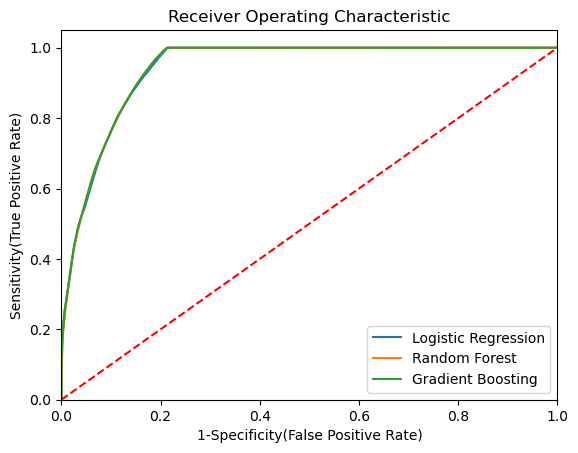

In [273]:
models = [
{
    'label': 'Logistic Regression',
    'model': log_reg,
},
{
    'label': 'Random Forest',
    'model': ran_for,
},
{
    'label': 'Gradient Boosting',
    'model': grad_b,
}
]

for m in models:
    model = m['model']
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # auc = roc_auc_score(y_test, model.predict(X_test))
    plt.plot(fpr, tpr, label=m['label'])
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 

All the models have nearly the same performance. This may be caused by small number of variables. Taking business requirements into account we could operate the threshold to play with TPR and FPR.

### Final prediction

In [274]:
print('Logistic regression, final prediction result:\n', classification_report(y_validate, log_reg.predict(X_validate)))

Logistic regression, final prediction result:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91    445408
           1       0.20      0.27      0.23     45125

    accuracy                           0.83    490533
   macro avg       0.56      0.58      0.57    490533
weighted avg       0.86      0.83      0.84    490533



In [275]:
print('Random forest, final prediction result:\n', classification_report(y_validate, ran_for.predict(X_validate)))

Random forest, final prediction result:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86    445408
           1       0.16      0.38      0.23     45125

    accuracy                           0.76    490533
   macro avg       0.54      0.59      0.54    490533
weighted avg       0.86      0.76      0.80    490533



In [276]:
print('Gradient boosting, final prediction result:\n', classification_report(y_validate, grad_b.predict(X_validate)))

Gradient boosting, final prediction result:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89    445408
           1       0.18      0.32      0.23     45125

    accuracy                           0.81    490533
   macro avg       0.55      0.59      0.56    490533
weighted avg       0.86      0.81      0.83    490533



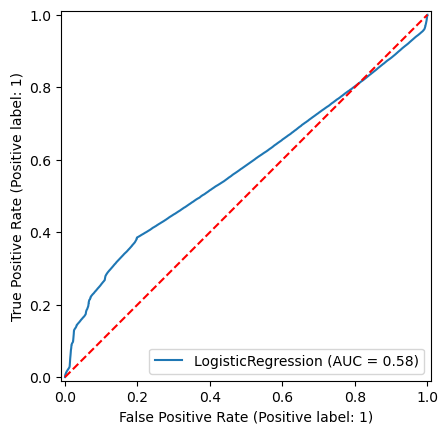

In [278]:
RocCurveDisplay.from_estimator(log_reg, X_validate, y_validate)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

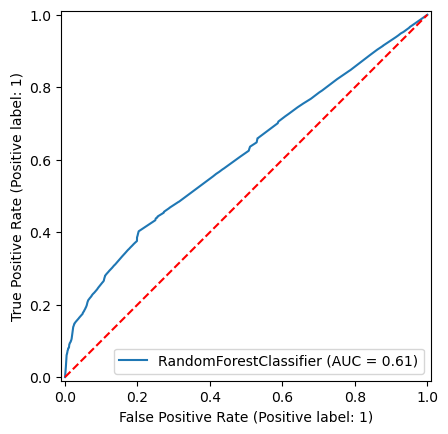

In [277]:
RocCurveDisplay.from_estimator(ran_for, X_validate, y_validate)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

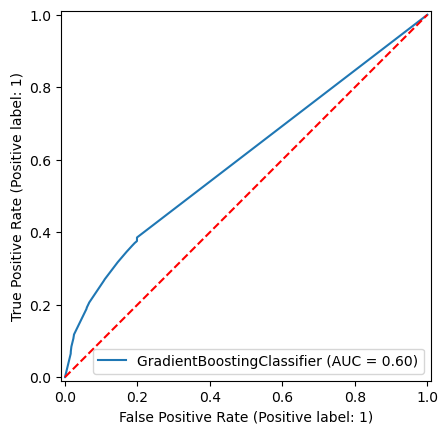

In [279]:
RocCurveDisplay.from_estimator(grad_b, X_validate, y_validate)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

**Conclusion:** The model is overfit and performs poorly on the validation set. Probably this is caused by small number of features, so getting more data columns would make it perform better.